In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import json
import ast
import scipy

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import math

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

cwd = os.getcwd()

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator

## Dataframe loading

In [3]:
from keras.preprocessing.image import ImageDataGenerator
# create generator
datagen = ImageDataGenerator()
# prepare an iterators for each dataset
train_it = datagen.flow_from_directory('TinyImageNet/train', class_mode='sparse',shuffle=False,batch_size=32,target_size=(64, 64))
val_it = datagen.flow_from_directory('TinyImageNet/val', class_mode='sparse',shuffle=False,batch_size=32,target_size=(64, 64))

Found 3000 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [4]:
val_it.n

300

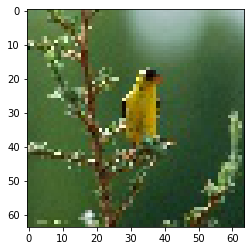

In [5]:
# PRINT IMAGE FROM THE DATASET
from matplotlib import pyplot
# load image as pixel array
image = tf.keras.utils.array_to_img(train_it[44][0][2])
# display the array of pixels as an image
pyplot.imshow(image)
pyplot.show()

In [6]:
img_h, img_w = 64, 64
num_classes = 3

## Defining network architecture

In [7]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, inputs, targets, test_image_indices):

  # Initialize the interpreter
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices),), dtype=int)
    for i, test_image_index in enumerate(test_image_indices):
        #print(test_image_index)
        test_image = inputs[test_image_index]
        test_label = targets[test_image_index]

        # Check if the input type is quantized, then rescale input data to uint8
        #print(input_details['dtype'])
        if input_details['dtype'] == np.int8:
            #print("correct")
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
        interpreter.set_tensor(input_details["index"], test_image)
        interpreter.invoke()
        output = interpreter.get_tensor(output_details["index"])[0]
        #print(output)
        predictions[i] = output.argmax()

    return predictions

In [8]:
def train_network(MP_dim2, conv_kernel_w2, conv_kernel_h2, conv_block2, drop_out_rate2, start_f2, regularizer, inputs, targets, dilation_rate, fraction, average_pooling):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training model with MP {MP_dim2}, conv kernel{[conv_kernel_w2, conv_kernel_h2]}, {conv_block2} blocks, {start_f2} filters, average pooling layer {average_pooling}, {drop_out_rate2} do...')
    experiment = "Tiny_ImageNet_test_4"
    
    #fold_no = 1
    
    #--------------------------------STATIC PARAMETERS------------------------------------------
    # Define the K-fold Cross Validator
    #kfold = KFold(n_splits=10, shuffle=True)
    #loo = LeaveOneOut()
    
    
    # Optimization params
    # -------------------

    # Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()

    # learning rate
    lr = 0.3e-4
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    # -------------------

    # Validation metrics
    # ------------------

    metrics = ['accuracy']

    batch_size = 32
    
    n_epoch = 400
    
    
    #------------------------------------CALLBACKS----------------------------------------
    callbacks = []
    
    # Early Stopping
    # --------------
    early_stop = False
    if early_stop:
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=False,)
        callbacks.append(es_callback)
    
    # ----------------------------------CROSSVALIDATION----------------------------------- 
    # Define the model architecture
    print(f'{MP_dim2}, {[conv_kernel_w2, conv_kernel_h2]}, {conv_block2}, {start_f2}, {drop_out_rate2}...')
    model = tf.keras.Sequential()

    input_shape = [img_h, img_w, 3]

    model.add(tf.keras.layers.MaxPool2D(pool_size=(MP_dim2, MP_dim2), input_shape=input_shape))

    n_filters = start_f2

    for i in range(conv_block2):
        # Conv block: Conv2D -> Conv2D -> Activation -> Pooling
        model.add(tf.keras.layers.Conv2D(filters=n_filters, 
                                         kernel_size=(conv_kernel_w2, conv_kernel_h2),
                                         strides=(1, 1),
                                         dilation_rate = dilation_rate,
                                         padding='same'))
        model.add(tf.keras.layers.Conv2D(filters=n_filters, 
                                         kernel_size=(conv_kernel_h2, conv_kernel_w2),
                                         strides=(1, 1),
                                         dilation_rate = dilation_rate,
                                         padding='same',
                                         activation = 'relu'))  
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    # AVERAGE POOLING
    if average_pooling:
        sizew = math.floor(64/4)
        sizeh = math.floor(64/4)
        for i in range (1, conv_block2):
            sizew = math.floor(sizew/2)
            sizeh = math.floor(sizeh/2)
        model.add(tf.keras.layers.AveragePooling2D(pool_size=(sizew, sizeh)))


    # Classifier

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(drop_out_rate2))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizer))

    # Compile the model
    model.compile(loss=loss,
                optimizer=optimizer,
                metrics=['accuracy'])
    # Fit data to model
    #class_weights={0: balancing0, 1: balancing1, 2: balancing2}
    history = model.fit(inputs,
                batch_size=batch_size,
                epochs=n_epoch,
                validation_data=(val_it),
                steps_per_epoch = inputs.n//inputs.batch_size,
                validation_steps = val_it.n//val_it.batch_size,
                callbacks = callbacks,
                verbose=True
                )
    
    accuracy = history.history['val_accuracy']
    loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']

    #-------------------------------SAVE MODEL-----------------------------------------

    MODELS_DIR = f'models/experiment_{experiment}/fraction_{fraction}/n_epoch_{n_epoch}/{MP_dim2}-{conv_kernel_w2}-{conv_kernel_h2}-{conv_block2}-{start_f2}-{drop_out_rate2}-{dilation_rate}--{average_pooling}/'
    try:
        if not os.path.exists(MODELS_DIR):
            os.makedirs(MODELS_DIR)
    except e:
        if e.errno != errno.EEXIST:
            raise   
        # time.sleep might help here
        pass

    MODEL_TF = MODELS_DIR
    model.save(MODEL_TF)
    # Increase fold number


        #--------------------------QUANTIZE THE MODEL ----------------------------------

    #print(f"accuracy: {np.array(acc_per_fold)[:, -1]}")
    #print(train_acc_per_fold_quant)"""
        
    print(model.summary())
    
    #---------------------------SAVE RESULTS TO JSON---------------------------------------
    row = {'MaxPoolDim' : MP_dim2, 
           'conv_kernel_dim' : [conv_kernel_w2, conv_kernel_h2], 
           'n_conv' : conv_block2, 
           'n_filters' : start_f2, 
           'dropout' : drop_out_rate2, 
           'n_epochs' : n_epoch,
           'dilation_rate' : dilation_rate,
           'average_pooling' : average_pooling,
           'train_accuracy' : accuracy,
           'valid_accuracy' : accuracy
          }
    JSON_DIR = f'json_child/experiment_{experiment}/fraction_{fraction}/n_epoch_{n_epoch}'
    if not os.path.exists(JSON_DIR):
        os.makedirs(JSON_DIR)
    try:
        with open(f'{JSON_DIR}/{MP_dim2}-{conv_kernel_w2}-{conv_kernel_h2}-{conv_block2}-{start_f2}-{drop_out_rate2}-{dilation_rate}--{average_pooling}.json', 'w') as f:
            json.dump(row, f)
    except Exception as e:
        print(e)
        
    
    #--------------------------PLOT ACCURACIES CURVES ------------------------------
    plt.clf()
    plt.plot(np.mean(train_accuracy, axis=0))
    plt.plot(np.mean(accuracy, axis=0))
    plt.savefig(f'{JSON_DIR}/{MP_dim2}-{conv_kernel_w2}-{conv_kernel_h2}-{conv_block2}-{start_f2}-{drop_out_rate2}-{dilation_rate}--{average_pooling}.png')
    plt.close()
    
    
    return 1

## Perform grid search

In [9]:
train = train_it
validation = val_it
#targets = train_label

#-----------------------------------GRID SEARCH PARAMETERS ---------------------------

#firts MaxPool dimension, to reduce the input size.
MP_dims = [2]

#kernel dimension of filters. 
conv_kernels = [[3, 3],[5,5]]

#number of convolution blocks
conv_blocks = [1, 2, 3, 4] #TRY 2 AND 3

#Dropout rate
drop_out_rates = [0.3]

#number of filters in each convolutional layer
start_fs =  [12, 16, 20]

#regularizers to use in the network
regularizers = [None]#, regularizers.l2(1e-4), regularizers.l2(1e-5), regularizers.l2(1e-3)]

#dilation rates of the convolutional layers
dilation_rates = [1]

#include average pooling layer
average_pooling = [False] #True, False like [True, False]

n_models = len(MP_dims) * len(conv_kernels) * len(conv_blocks) * len(start_fs) * len(drop_out_rates) * len(dilation_rates) * len(average_pooling)

print(f"{n_models} will be trained")

24 will be trained


In [ ]:
fraction=3

def train_one(arg):
    train_network(arg[0], arg[1], arg[2],arg[3],arg[4], arg[5], arg[6], arg[7], arg[8], arg[9], arg[10], arg[11])

def train_all(args):
    execution = 0;
    for elem in args:
        execution +=1
        print(f"Execution nº {execution}")
        train_one(elem)
    return 0


if __name__ == "__main__":
    args = []
    for MP_dim in MP_dims:
        for conv_kernel in conv_kernels:
            for conv_block in conv_blocks:
                for drop_out_rate in drop_out_rates:
                    for start_f in start_fs:
                        for regularizer in regularizers:
                            for dilation_rate in dilation_rates:
                                for avg_pooling in average_pooling:
                                    args.append([MP_dim, conv_kernel[0], conv_kernel[1], conv_block, drop_out_rate, start_f, regularizer, train, validation, dilation_rate, fraction, avg_pooling])

    results = train_all(args)

## Results are saved on a .json file